In [1]:
__author__ = 'Monika Soraisam'
__email__ = 'monika.soraisam@noirlab.edu'

### Set up DRAGONS

In [2]:
import os
from pathlib import Path
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime

import urllib
import shutil
import subprocess

In [3]:
# Now import the DRAGONS libraries 
import astrodata
import gemini_instruments
from recipe_system import cal_service
from gempy.adlibrary import dataselect
from gempy.utils import logutils

from recipe_system.reduction.coreReduce import Reduce
from gempy.scripts import showpars
from gempy.utils.showrecipes import showrecipes
from gempy.utils.showrecipes import showprims

In [4]:
## prep the reduction folder
def prep_reduction_folder(data_root, obsid):
    reduction_path = Path(f"{data_root}/{obsid}/reduction")

    if not reduction_path.exists():
        os.mkdir(reduction_path.as_posix())
        print (f"directory for dragons reduction created")
    
    ## change the cwd to the reduction folder
    os.chdir(reduction_path.as_posix())
    print(f"Current working directory is: {os.getcwd()}")

    ## write the configuration file 
    mydb = "dragons_for_goats.db" 
    mydb_path = reduction_path.as_posix() + '/' + mydb
    print (mydb_path)
    
    dragons_rc = reduction_path.as_posix() + '/dragonsrc'
    print (dragons_rc)
    
    with open(dragons_rc, "w") as f:
        f.write("[calibs]\ndatabases = {0} get store".format(mydb_path))

    return dragons_rc, mydb_path


### NIRI imaging -- GN-2016B-FT-16-9

In [5]:
data_path = "/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM"
obsid = 'GN-2016B-FT-16-9'  
dragons_rc, mydb_path = prep_reduction_folder(data_path, obsid)

directory for dragons reduction created
Current working directory is: /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/dragons_for_goats.db
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/dragonsrc


In [6]:
# initialize the calibration database and complete the set-up 
caldb = cal_service.LocalDB(mydb_path, force_init=True) # 


2024-08-28 10:55:40 STDINFO  - Local database file /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/dragons_for_goats.db does not exist. Initializing.
Local database file /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/dragons_for_goats.db does not exist. Initializing.


### Generate filelist for the data reduction

In [7]:
def generate_filelists(location, obsid):
    """
    Parameters
    ----------
    location: str
        Root folder where the Gemini data for a given target is located
    obsid: str
        Gemini observation ID 
    """

    
    all_files = [str(pp) for pp in list(Path(location+"/"+obsid).glob('*.fits'))]
    all_files.sort()
    print (f'The total number of files for observation ID {obsid} is {len(all_files)}')

    obs_types = ['OBJECT','BIAS','DARK','FLAT','ARC','PINHOLE','RONCHI','CAL','FRINGE','MOS MASK', 'BPM'] #fetched from Obs Type search field on GOA, which is relevant for DRAGONS

    all_meta = {}

    # Note that even if a few keywords are extracted below, thiis is just meant for demonstration purposes. 
    # If onyl these keywords are extracted in production, it will not align with  
    # implementation of item (2), allowing users to group/select preferred header keywords
    for K in obs_types:
        all_meta[K] = {'file':[],
                        'obs_class':[],
                        'group_id':[],
                        'exp':[],
                        'object':[],
                        'wave':[],
                        'waveband':[],
                        'date':[],
                        'roi':[],
                        }

    object_files = []
    for i,F in enumerate(all_files):
        ad = astrodata.open(F)

        if "BPM" in ad.tags or "UNPREPARED" in ad.tags: ## want only raw, i.e., "unprepared" files, but BPM is an exception, which is processed/prepared 
            K = ad.observation_type() ## astrodata header also has the observation type, which should match what's in the archive drop-down menu
        
        elif "PREPARED" in ad.tags or "PROCESSED" in ad.tags: ## skip all "prepared"/"processed" files
            continue
            
        all_meta[K]['file'].append(F)
        all_meta[K]['obs_class'].append(ad.observation_class())
        
        # group_id seems to be not implemented for GNIRS spectroscopy yet
        if "GNIRS" in ad.instrument():
            all_meta[K]['group_id'].append(None)
        else:
            all_meta[K]['group_id'].append(ad.group_id())
        all_meta[K]['exp'].append(ad.exposure_time())
        all_meta[K]['object'].append(ad.object())
        all_meta[K]['wave'].append(ad.central_wavelength())
        all_meta[K]['waveband'].append(ad.wavelength_band())
        all_meta[K]['date'].append(ad.ut_date())
        all_meta[K]['roi'].append(ad.detector_roi_setting()) 
        #print (F.split('/')[-1], ad.object(), ad.tags)
    
    return all_meta


In [8]:
all_meta = generate_filelists(data_path, obsid)

for K,V in all_meta.items():
    if len(V['file'])==0:
        continue
    print (f"There are {len(V['file'])} files for observation type {K}") 

The total number of files for observation ID GN-2016B-FT-16-9 is 109
There are 42 files for observation type OBJECT
There are 10 files for observation type DARK
There are 56 files for observation type FLAT
There are 1 files for observation type BPM


In [9]:
## extract all_meta into pandas datafrmaes
DF_dark = pd.DataFrame(all_meta['DARK'])
DF_flat = pd.DataFrame(all_meta['FLAT'])
DF_object = pd.DataFrame(all_meta['OBJECT'])
DF_bpm = pd.DataFrame(all_meta['BPM'])

In [10]:
print (f"There are {len(np.unique(DF_object['object'].values))} science targets in this observation set, namely {np.unique(DF_object['object'].values)}")

There are 3 science targets in this observation set, namely ['FS 3' 'FS-103' 'iPTF-16fnl']


In [11]:
for K, V in DF_object.groupby('group_id'):
    print (K, len(V), f"for this sequence of observations for the science target, minimum date of observation is {min(V['date'])} and maximum date is {max(V['date'])}")

GN-2016B-FT-16-11_H_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 5 for this sequence of observations for the science target, minimum date of observation is 2016-10-12 and maximum date is 2016-10-12
GN-2016B-FT-16-11_K(short)_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 5 for this sequence of observations for the science target, minimum date of observation is 2016-10-12 and maximum date is 2016-10-12
GN-2016B-FT-16-9_H_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 9 for this sequence of observations for the science target, minimum date of observation is 2016-10-12 and maximum date is 2016-10-12
GN-2016B-FT-16-9_K(short)_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 18 for this sequence of observations for the science target, minimum date of observation is 2016-10-12 and maximum date is 2016-10-12
GN-2016B-Q-33-164_K(short)_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 5 for this sequence of observations for the science target, minimum date of observation is 2016-10-13 a

In [12]:
logutils.config(file_name='niri_data_reduction.log') # logger

## Add the BPM to the calibration database

In [13]:
for F in DF_bpm['file'].values:
    caldb.add_cal(F)

In [14]:
def dragons_reduce(filelist, alt_recipe=None, uparams=None, config_file=None):
    """
    Parameters
    ----------
    filelist: list 
        list of files of a given observation type
    alt_recipe: str
        alternative recipe name, if not using the default recipe
    uparams: list of tuples
        user supplied parameters for primitives in the recipe 
    config_file : str
        full path of the dragons config file to use 
    """
    reduce = Reduce()
    reduce.files.extend(filelist)
    if alt_recipe is not None:
        reduce.recipename = alt_recipe
    if uparams is not None:
        reduce.uparms = uparams 
        print (reduce.uparms)
    if config_file is not None:
        reduce.config_file = config_file
    print (f"Showing primitives of the recipe to be used:\n {showprims(filelist[0])}")
    reduce.runr()
    return reduce

### Process dark

In [ ]:
for K, V in DF_dark.groupby(["exp"]):
    print (K, len(V))
    reduce = dragons_reduce(list(V['file'].values), config_file=dragons_rc)

In [16]:
# Let's see how many files are now registered in the calibration database
for F in caldb.list_files():
    print (F)

FileData(name='N20161012S0380_dark.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/calibrations/processed_dark')
FileData(name='bpm_20010317_niri_niri_11_full_1amp.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9')


### Process flat

In [ ]:
for K, V in DF_flat.groupby('group_id'):
    print (K, len(V), "\n")
    reduce = dragons_reduce(list(V['file'].values), config_file=dragons_rc)

In [18]:
# Let's see how many files are now registered in the calibration database
for F in caldb.list_files():
    print (F)

FileData(name='N20161012S0350_flat.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/calibrations/processed_flat')
FileData(name='N20161012S0370_flat.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/calibrations/processed_flat')
FileData(name='N20161012S0380_dark.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/calibrations/processed_dark')
FileData(name='N20161013S0567_flat.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/calibrations/processed_flat')
FileData(name='bpm_20010317_niri_niri_11_full_1amp.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9')


### Process object

**For this obs_ID, 'FS 3' 'FS-103' are standard stars. For NIRI imaging, dark correction is not done for standards. See https://dragons.readthedocs.io/projects/niriimg-drtutorial/en/release-3.2.x/ex1_niriim_extended_cmdline.html**

In [ ]:
for K, V in DF_object.groupby('group_id'):
    print (K, len(V), "object name: ", np.unique(V['object'].values), "\n")      
    if np.unique(V['object'].values) != "FS 3":
        continue
    reduce = dragons_reduce(list(V['file'].values), config_file=dragons_rc, uparams=[('darkCorrect:do_cal', 'skip')])

In [20]:
for K, V in DF_object.groupby('group_id'):
    print (K, len(V), "object name: ", np.unique(V['object'].values), "\n")      
    # Fortunately, for this obs_ID, only a unique object is contained within each group, so can proceed with the science reduction
    # only reducing the main science target iPTF-16fnl, because the archive did not assoicate dark calibration files for the standards (other two targets)
    if np.unique(V['object'].values) != "iPTF-16fnl":
        continue
    reduce = dragons_reduce(list(V['file'].values), config_file=dragons_rc)

All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/N20161012S0236.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/N20161012S0244.fits, 9 files submitted.


GN-2016B-FT-16-11_H_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 5 object name:  ['FS-103'] 

GN-2016B-FT-16-11_K(short)_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 5 object name:  ['FS-103'] 

GN-2016B-FT-16-9_H_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 9 object name:  ['iPTF-16fnl'] 

Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/N20161012S0236.fits
Input tags: ['RAW', 'GEMINI', 'SIDEREAL', 'NORTH', 'IMAGE', 'UNPREPARED', 'NIRI']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.niri.recipes.sq.recipes_IMAGE::reduce
Recipe location: /opt/anaconda3/envs/goats-env/lib/python3.10/site-packages/geminidr/niri/recipes/sq/recipes_IMAGE.py
Recipe tags: {'IMAGE', 'NIRI'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.removeFirstFrame()
   p.ADUToElectrons()
   p.addVAR(read_noise=True, poisson_noise=

RECIPE: reduce
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keyw

ValueError: Only 2 images but nlow=1 and nhigh=1

**You will see that the above crashes. I'm leaving it as it is because this is a corner case where the user needs to tweak parameters of a given primitive "skyCorrect" in this case.**

In [21]:
pobj, tags = showpars.get_pars(V['file'].values[0]) # returns the primitive class object and astrodata tags
showpars.showpars(pobj, 'skyCorrect', tags, show_docstring=None)

Dataset tagged as {'RAW', 'SIDEREAL', 'UNPREPARED', 'NIRI', 'NORTH', 'IMAGE', 'GEMINI'}

Settable parameters on 'skyCorrect':
Name                 Current setting      Description

suffix               '_skyCorrected'      Filename suffix
reset_sky            False                Replace lost sky counts?
scale_sky            True                 Scale sky frame to science frame?
offset_sky           False                Apply offset to sky frame to match science frame?
sky                  None                 Sky frame to subtract
save_sky             False                Save sky frame to disk?
apply_dq             True                 Use DQ to mask bad pixels?
statsec              None                 Section for statistics
operation            'median'             Averaging operation
Allowed values:
	mean	arithmetic mean
	wtmean	variance-weighted mean
	median	median
	lmedian	low-median

reject_method        'minmax'             Pixel rejection method
Allowed values:
	none	no rejec

**Let's change the "reject_method" to one of the allowed values that is not "minmax" -- choose "sigclip" -- and run the reduction for the standard star again**

In [22]:
for K, V in DF_object.groupby('group_id'):
    print (K, len(V), "object name: ", np.unique(V['object'].values), "\n")      
    # Fortunately, for this obs_ID, only a unique object is contained within each group, so can proceed with the science reduction
    # only reducing the main science target iPTF-16fnl, because the archive did not assoicate dark calibration files for the standards (other two targets)
    if np.unique(V['object'].values) != "iPTF-16fnl":
        continue
    
    reduce = dragons_reduce(list(V['file'].values), uparams=[('skyCorrect:reject_method', 'sigclip')], 
                            config_file=dragons_rc)

All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/N20161012S0236.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/N20161012S0244.fits, 9 files submitted.


GN-2016B-FT-16-11_H_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 5 object name:  ['FS-103'] 

GN-2016B-FT-16-11_K(short)_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 5 object name:  ['FS-103'] 

GN-2016B-FT-16-9_H_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 9 object name:  ['iPTF-16fnl'] 

[('skyCorrect:reject_method', 'sigclip')]
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/N20161012S0236.fits
Input tags: ['RAW', 'GEMINI', 'SIDEREAL', 'NORTH', 'IMAGE', 'UNPREPARED', 'NIRI']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.niri.recipes.sq.recipes_IMAGE::reduce
Recipe location: /opt/anaconda3/envs/goats-env/lib/python3.10/site-packages/geminidr/niri/recipes/sq/recipes_IMAGE.py
Recipe tags: {'IMAGE', 'NIRI'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.removeFirstFrame()
   p.ADUToElectrons()
 

RECIPE: reduce
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keyw

GN-2016B-FT-16-9_K(short)_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 18 object name:  ['iPTF-16fnl'] 

[('skyCorrect:reject_method', 'sigclip')]
Showing primitives of the recipe to be used:
 Recipe not provided, default recipe (reduce) will be used.
Input file: /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/N20161012S0245.fits
Input tags: ['RAW', 'GEMINI', 'SIDEREAL', 'NORTH', 'IMAGE', 'UNPREPARED', 'NIRI']
Input mode: sq
Input recipe: reduce
Matched recipe: geminidr.niri.recipes.sq.recipes_IMAGE::reduce
Recipe location: /opt/anaconda3/envs/goats-env/lib/python3.10/site-packages/geminidr/niri/recipes/sq/recipes_IMAGE.py
Recipe tags: {'IMAGE', 'NIRI'}
Primitives used: 
   p.prepare()
   p.addDQ()
   p.removeFirstFrame()
   p.ADUToElectrons()
   p.addVAR(read_noise=True, poisson_noise=True)
   p.nonlinearityCorrect()
   p.darkCorrect()
   p.flatCorrect()
   p.separateSky()
   p.associateSky(stream='sky')
   p.skyCorrect(instream='sky',

RECIPE: reduce
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keywords that are specific to NIRI
         Updating keyw

GN-2016B-Q-33-164_K(short)_f6_Medium Background_Shallow_['[1:1024,1:1024]'] 5 object name:  ['FS 3'] 



#### See that the final data product is finally present in the reduction folder 

In [23]:
!ls /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/*image.fits

/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/N20161012S0238_image.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/N20161012S0247_image.fits
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/N20161013S0231_image.fits


Filename: /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/N20161012S0247_image.fits
Tags: GEMINI IMAGE NIRI NORTH PREPARED PROCESSED PROCESSED_SCIENCE SIDEREAL

Pixels Extensions
Index  Content                  Type              Dimensions     Format
[ 0]   science                  NDAstroData       (1623, 1769)   float32
          .variance             ADVarianceUncerta (1623, 1769)   float32
          .mask                 ndarray           (1623, 1769)   uint16

Other Extensions
               Type        Dimensions
.HISTORY       Table       (18, 4)
.PROVENANCE    Table       (16, 4)


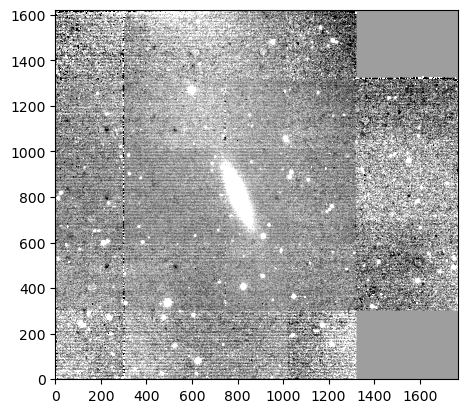

In [24]:
# plotting one of the reduced images

plt.close('all')
fig, ax = plt.subplots()
ad = astrodata.open("/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2016B-FT-16-9/reduction/N20161012S0247_image.fits")
ad.info()
ax.imshow(ad[0].data, origin="lower", cmap='grey', vmin=np.percentile(ad[0].data, 10), vmax=np.percentile(ad[0].data, 80))
plt.show()